# Importing the Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
import plotly.graph_objects as go
import umap

In [2]:
from nltk.corpus import stopwords

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Initial Preprocessing

In [6]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [7]:
train_texts = [text for text in df_train['comment_text']]
test_texts = [text for text in df_test['comment_text']]

In [8]:
labels_toxic = [val for val in df_train['toxic']]
labels_severe_toxic = [val for val in df_train['severe_toxic']]
labels_obscene = [val for val in df_train['obscene']]
labels_threat = [val for val in df_train['threat']]
labels_insult = [val for val in df_train['insult']]
labels_identity_hate = [val for val in df_train['identity_hate']]

In [9]:
def remove_special_symbols(texts):
    # Defining a regular expression pattern to match special symbols
    special_symbol_pattern = r'[^A-Za-z\s]'  # This pattern matches anything that is not a letter, digit, or whitespace

    # Creating a list to store the filtered texts
    filtered_texts = []

    # Iterating through each text and removing special symbols
    for text in texts:
        filtered_text = re.sub(special_symbol_pattern, '', text)
        filtered_texts.append(filtered_text)

    return filtered_texts

In [10]:
filtered_train_texts = remove_special_symbols(train_texts)
filtered_test_texts = remove_special_symbols(test_texts)

In [11]:
# Choosing max_features value
max_features = 500

# Initializing the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

# Fitting and transforming the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(filtered_train_texts)

# Transforming the test data
X_test_tfidf = tfidf_vectorizer.transform(filtered_test_texts)

In [12]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Preprocessing For Clustering

In [13]:
# Setting the seed for reproducibility
np.random.seed(42)

# Randomly sampling 10,000 indices
sampled_indices = np.random.choice(X_train_dense.shape[0], 10000, replace=False)

# Using the sampled indices to get the corresponding subset from X_train_dense
X_train_dense_sampled = X_train_dense[sampled_indices]

# Checking the shape of the sampled subset
print(f"Shape of sampled subset: {X_train_dense_sampled.shape}")

Shape of sampled subset: (10000, 500)


In [14]:
# 56sec
# Initializing UMAP with the desired number of components
n_components_umap = 3

# Initializing UMAP model
umap_model = umap.UMAP(n_components=n_components_umap)

# Fitting and transforming the training data
X_train_umap_sampled = umap_model.fit_transform(X_train_dense_sampled)

# Printing the shape of the transformed data
print(f"X_train_umap_sampled shape: {X_train_umap_sampled.shape}")

X_train_umap_sampled shape: (10000, 3)


In [15]:
def visualize_clusters(X, n_clusters, clusters, algorithm):
  # Visualizing the clustered data in 3D
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')

  # Scatter plot for each cluster
  for cluster_id in range(n_clusters):
      cluster_points = X[clusters == cluster_id]
      ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_id + 1}', marker='o')

  # Adding labels and title
  ax.set_xlabel('Component 1')
  ax.set_ylabel('Component 2')
  ax.set_zlabel('Component 3')
  ax.set_title(f'{algorithm} Clustering of UMAP-transformed Sampled Data')
  ax.legend()

  # Showing the plot
  plt.show()

# K-Means

In [16]:
# Performing KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(X_train_umap_sampled)

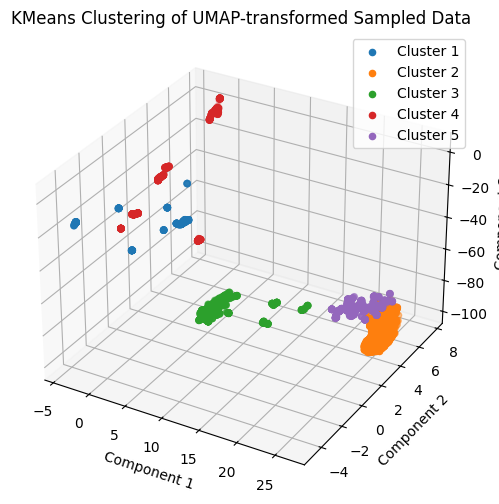

In [17]:
visualize_clusters(X_train_umap_sampled, n_clusters, clusters, 'KMeans')

Let's find the best number of clusters using Elbow Method.

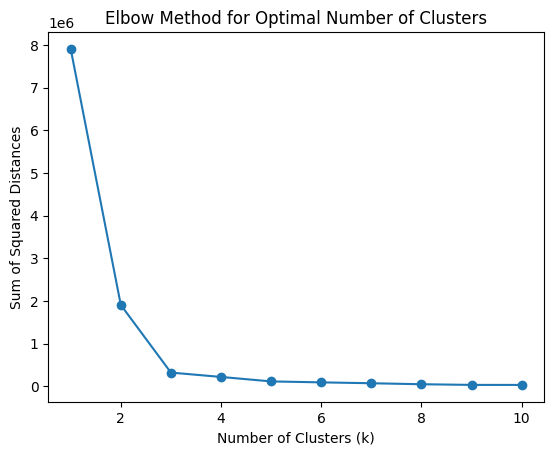

In [18]:
# Specifying a range of cluster numbers
max_clusters = 10
sum_squared_distances = []

# Calculating sum of squared distances for different numbers of clusters
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_train_umap_sampled)
    sum_squared_distances.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(1, max_clusters + 1), sum_squared_distances, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

**4** looks like the optimal number of clusters.

In [19]:
# Performing KMeans clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
clusters = kmeans.fit_predict(X_train_umap_sampled)

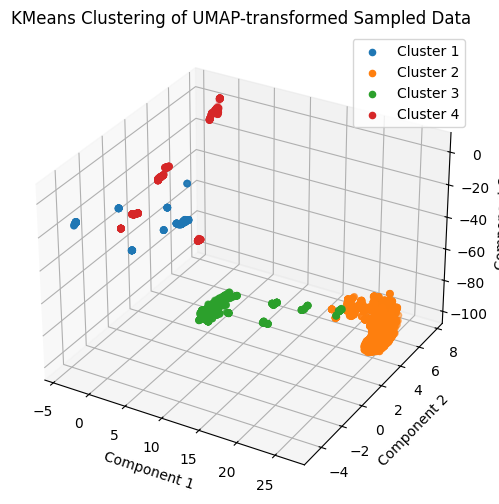

In [20]:
visualize_clusters(X_train_umap_sampled, n_clusters, clusters, 'KMeans')

# DBSCAN

In [21]:
# Performing DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)
clusters = dbscan.fit_predict(X_train_umap_sampled)

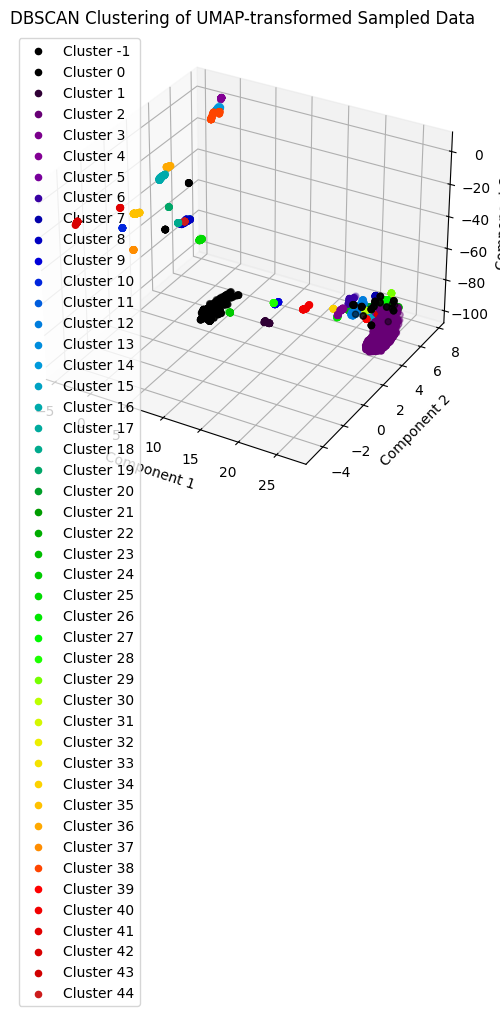

In [22]:
# Visualizing the clustered data in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
unique_clusters = np.unique(clusters)
for cluster_id in unique_clusters:
    if cluster_id == -1:
        # Outliers (noise points) are shown in black
        color = 'black'
    else:
        # Regular clusters are assigned different colors
        color = plt.cm.nipy_spectral(cluster_id / len(unique_clusters))

    cluster_points = X_train_umap_sampled[clusters == cluster_id]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_id}', color=color, marker='o')

# Adding labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('DBSCAN Clustering of UMAP-transformed Sampled Data')
ax.legend()

# Showing the plot
plt.show()

# Hierarchical Clustering

In [23]:
# Performing Agglomerative Clustering
n_clusters = 5
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
clusters = agg_clustering.fit_predict(X_train_umap_sampled)

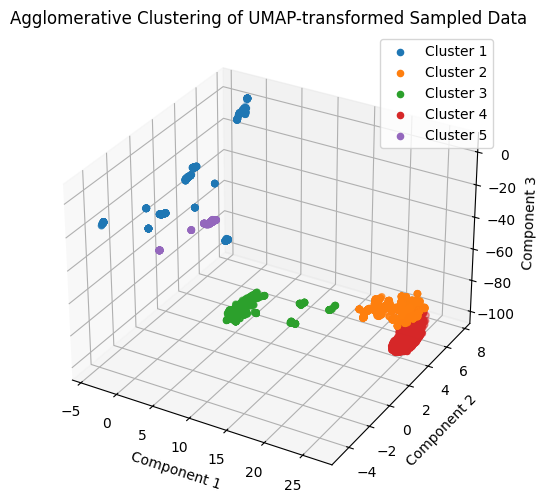

In [24]:
visualize_clusters(X_train_umap_sampled, n_clusters, clusters, 'Agglomerative')